# **Presentación**


## **Tecnicatura Universitaria en Inteligencia Artificial**
### *Trabajo Práctico Integrador*
### ***Aprendizaje Automatico 1***
---

**Equipo**:
- Ferrucci Constantino
- Giampaoli Fabio

<br>

**Fechas de entrega**:
- 27/10/2023 (segunda entrega hasta item 4)


---

## **Resumen**


Esta es la segunda parte del proyecto de la asignatura Aprendizaje Automatico 1. Puede consultar la parte 1 del mismo en el repositorio de [github](https://github.com/Shannon-21/Aprendizaje_Automatico_1.git), o bien el siguiente [notebook de Google Colab](https://colab.research.google.com/drive/1P32i9TmMZgLiKAblI0vKwltg7GMwnqvw?usp=sharing). En el se han realizado algunos cambios con respecto a la primera entrega, particualmente se han extraido los datasets de interes en forma de archivo csv, profundizado el analisis de residuos de los modelos, y removido la variable binaria RainTomorrow.\
<br>

La primera parte consiste en la limpieza del dataset ofrecido y obtencion de predicciones y metricas de las mismas sobre la cantidad de lluvia en las ciudades de Australia elegidas para el dia posterior al ingresado.\
<br>

El dataset elegido consiste de variables meteorologicas de Australia en determinado periodo de tiempo que seran de interes para la predicion de la presencia de lluvia en algun dia con ciertas caracteristicas mediante modelos estudiados en el cursado de la materia.\
<br>

En esta etapa del trabajo practico, es de principal interes el analisis y tratamiento del conjunto de datos para conocer el contexto sobre el cual vamos a desarrollarnos y entender como las variables explicativas afectan a nuestra variable de interes: 'RainTomorrow', que es una varible binaria. Luego realizar predicciones utilizando modelos de regresion logistica con diferentes caracteristicas, y comparar cual tiene mejor comportameinto a la hora de predecir la presencia de lluvia para el dia siguiente dada ciertas condiciones del dia previo.\
<br>

# **Entorno**

En este apartado es de interes cargar en el entorno todos los modulos externos que seran utilizados durante el desarrollo. Tambien se cargan en memoria los datasets, tanto la version normalizada del dataframe posprocesado, como su version desnormalizada.

### Librerias

In [1]:
%%capture
!pip install shap

In [2]:
# Procesamiento
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Visualizaciones
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
from tqdm import tqdm
import shap

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss

### Datos

In [3]:
df_denormalized = pd.read_csv('weatherAUS_desnormalized_cleaned.csv').iloc[:, 1:] # filtramos la primer columna por que pandas les suma un id inncesario
df = pd.read_csv('weatherAUS_cleaned.csv').iloc[:, 1:]

display(df.head(2))
display(df_denormalized.head(2))

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Month,Season,lat,lon
0,1.0,0.702994,0.599033,0.130653,0.260504,0.000000,0.943804,0.300000,0.668694,1.0,...,1.000,0.571429,0.405660,1.0,1.0,0.050251,0.0,0.0,1.0,1.0
1,1.0,0.714654,0.527430,0.050251,0.142857,0.194245,1.000000,0.235135,0.689550,0.0,...,0.875,0.615584,0.497642,1.0,1.0,0.055276,0.0,0.0,1.0,1.0


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Month,Season,lat,lon
0,0.426354,14.795156,24.925108,3.270007,5.586685,7.000102,0.371301,48.383105,0.351413,0.358342,...,7.241044,18.752999,22.639241,1.0,1.0,2.673692,0.083691,0.250254,-33.853302,151.269564
1,0.426354,14.848012,24.550043,2.676765,5.236419,7.727233,0.289469,47.439317,0.353460,0.278336,...,6.907489,18.998930,23.178137,1.0,1.0,2.710802,0.083691,0.250254,-33.853302,151.269564


# **Analisis Descriptivo**

Este bloque tiene intencion de mostrar relaciones y comportamiento de las variables, esta vez enfocados a la variable categorica.

### Balances

Se busca visulizar rapidamente la proporcion de las clases con las que trabajaremos.

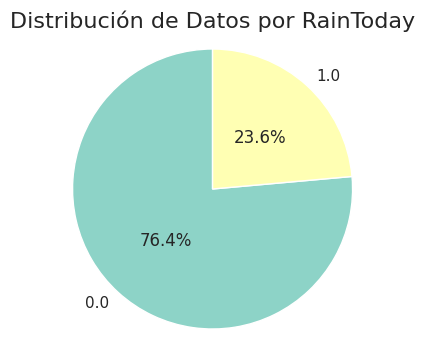

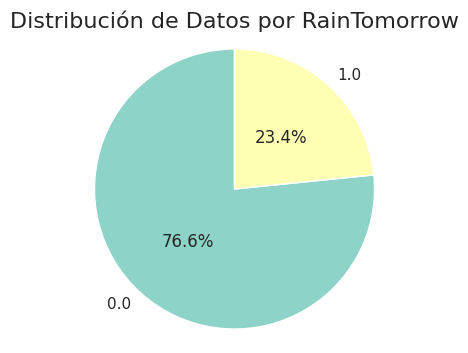

In [4]:
def graficar_proporcion_datos(df, column):
    value_counts = df[column].value_counts() # cantidad de calores de cada clase

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.5, colors=sns.color_palette('Set3')) # visualizacion en pie chart

    plt.title(f'Distribución de Datos por {column}', fontsize=16)
    plt.axis('equal')

    plt.show()

graficar_proporcion_datos(df_denormalized, 'RainToday')
graficar_proporcion_datos(df_denormalized, 'RainTomorrow')

Mostramos el balance de clases y observamos que estan desbalanceadas de forma proporcional, por lo que la misma tecnica para tratar el desbalanceo podria ser usada para ambas variables si fuera necesario.

### Proporciones

El siguiente grafico tiene la intencion de demostrar la proporcion de dias lluviosos y no lluviosos del dia siguiente, en base a si ha llovido el dia actual o no.

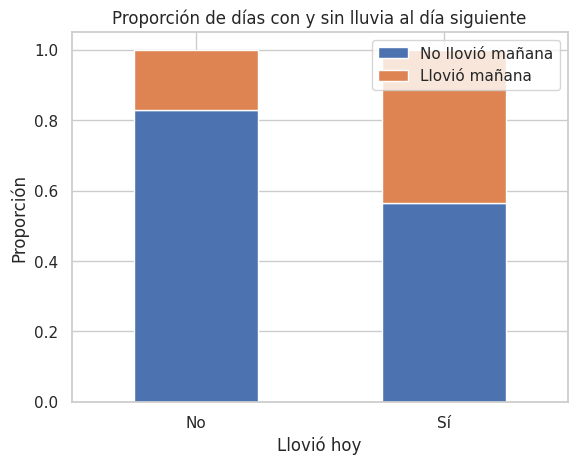

In [5]:
# Crear una tabla de contingencia (tabla de conteo de frequencias de clases)
contingency_table = pd.crosstab(df_denormalized['RainToday'], df_denormalized['RainTomorrow'])

# Calcular las proporciones
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Crear el gráfico de barras
proportions.plot(kind='bar', stacked=True)

plt.title('Proporción de días con y sin lluvia al día siguiente')
plt.xlabel('Llovió hoy')
plt.ylabel('Proporción')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.legend(['No llovió mañana', 'Llovió mañana'])

plt.show()

Este grafico insinua que en mas del 80% de los casos que no llueve el dia actual, tampoco llueve el dia siguiente. Y para aquellos dias que si llovio, en mas del 50% de los casos ha llovido el dia siguiente.

### Distribuciones

El suguiente tiene intencion de ser un grafico interactivo con el fin de entender el comportamiento de cada variable individualmente con respecto a la presencia de lluvia.

In [6]:
def create_plots(df, explanatory_var, binary_var):
    fig, axs = plt.subplots(3, 1, figsize=(6,6))

    # es un grafico de una sola dimension que le da grosor en el eje y solo por facilidad de visualizacion, separa las clases en colores
    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=binary_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + binary_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    # crea distribucion en boxplot de la variable separado por clase
    sns.boxplot(y=binary_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    # distribuciones de densidad por clases
    sns.kdeplot(data=df, x=explanatory_var, hue=binary_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

# Crear selector de variable explicativa
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in df_denormalized.columns if col not in ['RainToday', 'RainTomorrow', 'Location', 'lat', 'lon', 'Month', 'Season']],
    value='Sunshine',  # Valor predeterminado
    description='Explicativa:',
)

# crear selector de variable binaria
binary_var_widget = widgets.Dropdown(
    options=['RainToday', 'RainTomorrow'],
    value='RainToday',  # Valor predeterminado
    description='Binaria:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_plots, df=widgets.fixed(df_denormalized), explanatory_var=explanatory_var_widget, binary_var=binary_var_widget)

interactive(children=(Dropdown(description='Explicativa:', index=4, options=('MinTemp', 'MaxTemp', 'Rainfall',…

<function __main__.create_plots(df, explanatory_var, binary_var)>

Este grafico de gran utilidad para darnos una intuicion de que variables son mas explicativas para determinar la presencia de lluvia.

Por ejemplo, la variable Sunshine demuestra que mientras mas horas de sol ha recibido la ciudad en el dia, es menos comun que ese dia o el siguiente sea lluvioso. O que valores mas bajos de porcentaje de nubosidad indican menos propabilidad de lluvia.

### Correlaciones

Se muestra nuevamente una matrix de correlacion con el fin de ver rapidamente que variables presentan mayores correlaciones lineales, no solo con la variables objetivo, sino con todas las demas.

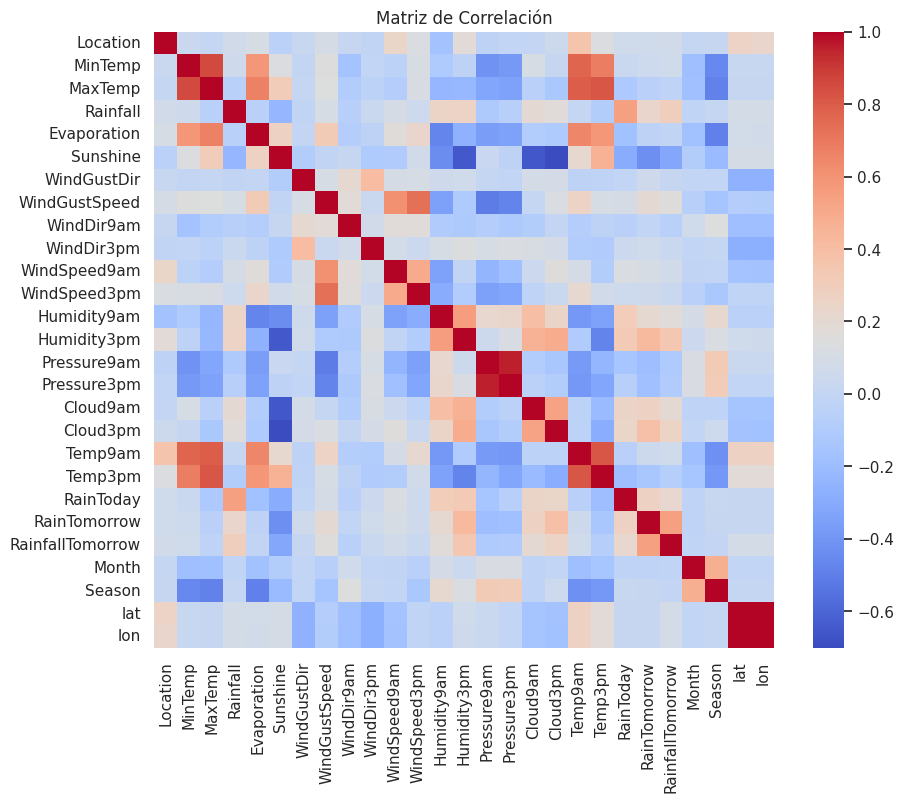

In [7]:
# Calcular la matriz de correlación
corr_matrix = df_denormalized.corr()

# Crear un mapa de calor con la matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación')
plt.show()


### Mañana

En el dataframe contamos con informacion de la cantidad de lluvia del dia siguiente de cada dia. Estas tienen cierta correlacion ya que en si tratan de explicar lo mismo: sobre la lluvia de mañana.

La realidad es que cuando usemos este modelo en produccion si fuera el caso, no contaremos con informacion del dia siguiente. Por ello es necsario quitarla del conjunto de entrenamiento.

In [8]:
df_denormalized = df_denormalized.drop('RainfallTomorrow', axis=1)
df = df.drop('RainfallTomorrow', axis=1)

# **Procesamiento**

Este apartado tiene intencion de realizar transformaciones que resultan ventajosas para la clasificacion. Por ejemplo, el tratamiento de desbalances o datos normalizados.

### Modelo Base

Este modelo tiene el objetivo de ser muy simple al hacer predicciones. En este caso usa un enfoque muy simple, y es que si el dia actual fue lluvioso, entonces el dia siguiente tambien.

Claramente esto no siempre ocurre como hemos visto, pero es una buena base para mejorar progresivamente.

In [9]:
def base_model_regressor(df):
    # Separar las variables explicativas y la variable objetivo
    X = df.drop(columns=['RainTomorrow'], axis=1)
    y = df['RainTomorrow']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Si llueve hoy, llueve maniana, sino llueve hoy, no llueve maniana
    y_train_pred = X_train['RainToday']
    y_pred = X_test['RainToday']

    # Calcular las métricas de clasificación
    metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Train': [accuracy_score(y_train, y_train_pred), precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)],
        'Test': [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)]
    }).set_index('Metric')

    return metrics

# Llamada a la función
base_model_regressor(df_denormalized)

,Train,Test
Metric,,
Accuracy,0.732955,0.744079
Precision,0.431983,0.445245
Recall,0.437281,0.440171
F1 Score,0.434616,0.442693


La salida de esta funcion es un dataframe que muestra las metricas tanto de entrenamiento como de testeo de las predicciones.

Los puntajes son bajos, como es de esperar.

### Balanceo de clases

Utilizaremos el metodo de over-sampling con K-Means (funcion SMOTENC) para tratar con el desbalanceo de las clases. Esto con el fin de mejorar la interpretacion del modelo a la hora de entrenarlo con los datos.

Notar que usamos el metodo SMOTENC debido a que el metodo SMOTE genera valores continuos para variables categoricas. De modo que generaba clases que en realidad no existe.

In [10]:

def over_classes(df, target_var):
    # Separar las variables explicativas y la variable objetivo
    X = df.drop(target_var, axis=1)
    y = df[target_var]

    categorical_features = X.columns.isin(['RainToday', 'RainTomorrow', 'Cloud3pm', 'Cloud9m', 'Location', 'WindGustDir','WindDir9am','WindDir3pm', 'Season', 'Month', 'Year'])

    # Crear el objeto SMOTENC
    smote = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    print(f'shape balanceado: {X_res.shape[0]}')

    # Devolver el DataFrame balanceado
    return pd.concat([X_res, y_res], axis=1)

# Llamada a la función
df_oversampling = over_classes(df_denormalized, 'RainTomorrow')
print(f'shape original: {df_denormalized.shape[0]}')

shape balanceado: 23286
shape original: 15199


Notamos que ha generado mas registros para la clase de dia lluvioso, ya que era la de menor proporcion.

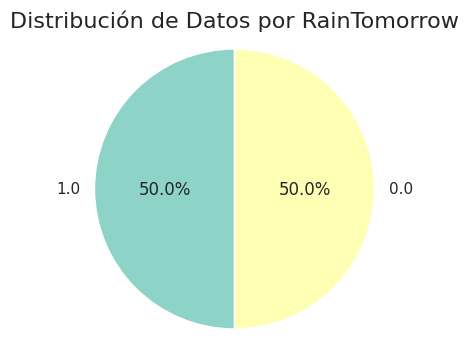

,Train,Test
Metric,,
Accuracy,0.620518,0.622585
Precision,0.702159,0.716120
Recall,0.413622,0.424704
F1 Score,0.520583,0.533192


In [11]:
graficar_proporcion_datos(df_oversampling, 'RainTomorrow')
base_model_regressor(df_oversampling)

Se presenta cierta mejoria, pero siguen siendo puntajes bajos.

Podemos probar balanceado tambien la variable RainToday que estaba desbalanceada tambien, con el finde ver si mejora la prediccion.

In [12]:
df_oversampling_t = over_classes(df_oversampling, 'RainToday')
base_model_regressor(df_oversampling_t)

shape balanceado: 32836


,Train,Test
Metric,,
Accuracy,0.666514,0.670219
Precision,0.747713,0.752877
Recall,0.642745,0.648071
F1 Score,0.691267,0.696554


En este caso si logra un mejor rendimiento. Pero es importante notar que se debe a la naturaleza del modelo base, que usa estas dos variables para predecir.

In [13]:
def under_classes(df, target_var):
    # Separar las variables explicativas y la variable objetivo
    X = df.drop(target_var, axis=1)
    y = df[target_var]

    # Crear el objeto NearMiss con parametros por default
    near = NearMiss()
    X_res, y_res = near.fit_resample(X, y)

    print(f'shape balanceado: {X_res.shape[0]}')

    # Devolver el DataFrame balanceado
    return pd.concat([X_res, y_res], axis=1)


In [14]:
df_undersampling = under_classes(df_denormalized, 'RainTomorrow')
print(f'shape original: {df_denormalized.shape[0]}')
base_model_regressor(df_undersampling)

shape balanceado: 7112
shape original: 15199


,Train,Test
Metric,,
Accuracy,0.632800,0.612790
Precision,0.720183,0.662996
Recall,0.439622,0.430615
F1 Score,0.545968,0.522116


Probamos nuevamente balancear la clase RainToday

In [15]:
df_undersampling_t = under_classes(df_undersampling, 'RainToday')
base_model_regressor(df_undersampling_t)

shape balanceado: 4396


,Train,Test
Metric,,
Accuracy,0.718714,0.707955
Precision,0.714526,0.681928
Recall,0.726340,0.693627
F1 Score,0.720385,0.687728


A pesar de que hemos perdido un gran proporcion de datos, el modelo ha mejorado sus metricas, sin embargo notamos peor rendimiento en las metricas de testing que de entrenamiento, lo que indica que este modelo esta sobreajustando los datos.

### Balanceo con modelo multivariable

Como el modelo base es es tan simple como decir que llueve mañana si el dia de hoy llovio, claramente las metricas del modelo cuando trabajamos estos balanceos se ven afectadas por esta logica. Por ello realizamos nuevamente estas pruebas pero con un modelo multivariable mas complejo.

In [16]:
def base_logistic_regressor(df, weights=None):
    # Separar las variables explicativas y la variable objetivo
    X = df.drop(columns=['RainTomorrow'], axis=1)
    y = df['RainTomorrow']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo de regresión logística
    model = LogisticRegression(class_weight=weights, max_iter=10000)
    model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calcular las métricas de clasificación
    metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Train': [accuracy_score(y_train, y_train_pred), precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)],
        'Test': [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)]
    }).set_index('Metric')

    return metrics

In [17]:
base_logistic_regressor(df_denormalized)

,Train,Test
Metric,,
Accuracy,0.838145,0.842434
Precision,0.723964,0.727088
Recall,0.501752,0.508547
F1 Score,0.592715,0.598491


In [18]:
df_oversampling = over_classes(df_denormalized, 'RainTomorrow')
display(base_logistic_regressor(df_oversampling))

df_oversampling_t = over_classes(df_oversampling, 'RainToday')
base_logistic_regressor(df_oversampling_t)

shape balanceado: 23286


,Train,Test
Metric,,
Accuracy,0.784250,0.788536
Precision,0.779906,0.792037
Recall,0.789740,0.791032
F1 Score,0.784793,0.791534


shape balanceado: 32836


,Train,Test
Metric,,
Accuracy,0.809654,0.808922
Precision,0.820763,0.824002
Recall,0.860139,0.855579
F1 Score,0.839990,0.839494


Vemos que con el segundo balanceado de clases el modelo logra metricas superiores, ya que ambas clases estan balanceadas en este punto.

Este metodo tiene la concecuencia de que aumentan significamente la cantidad de datos con registros sinteticos, ya que pasamos de 15mil filas aproximadamente a 32mil.

In [19]:
df_undersampling = under_classes(df_denormalized, 'RainTomorrow')
display(base_logistic_regressor(df_undersampling))

df_undersampling_t = under_classes(df_undersampling, 'RainToday')
base_logistic_regressor(df_undersampling_t)

shape balanceado: 7112


,Train,Test
Metric,,
Accuracy,0.759536,0.747013
Precision,0.778110,0.743885
Recall,0.729086,0.739628
F1 Score,0.752801,0.741750


shape balanceado: 4396


,Train,Test
Metric,,
Accuracy,0.773891,0.772727
Precision,0.787642,0.758706
Recall,0.748575,0.747549
F1 Score,0.767612,0.753086


Eliminar regristos del conjunto no solo es peor a la hora de hacer precciones, si no que con este enfoque estamos perdiendo gran cantidad de informacion a la hora de entrena el modelo.

Tambien podemos probar con el enfoque de darle pesos a las clases, de esta forma no perdemos ni aumentamos la informacion existente.

In [20]:
# le damos tres veces mas peso a dias lluviosos debido al balance visto al inicio
base_logistic_regressor(df_denormalized, {0:1, 1:3})

,Train,Test
Metric,,
Accuracy,0.778436,0.789145
Precision,0.519792,0.530288
Recall,0.736160,0.760684
F1 Score,0.609339,0.624927


Este enfoque no resulta mejor que los metodos previos a pesar de que la cantidad de registros se mantiene como el conjunto original.

### Seleccion de caracteristicas

Probamos reducir el conjunto de datos solo las variables mas explicativas encontradas de forma manual.

In [21]:
def get_correlation_with_variable(df, column): # para obtener correlaciones con la variable objetivo
  correlation_matrix = df.corrwith(df[column])
  correlation_matrix = correlation_matrix.to_frame(name='correlation')
  correlation_matrix = correlation_matrix.abs()
  sorted_correlation_matrix = correlation_matrix.sort_values(by='correlation', ascending=False)

  return sorted_correlation_matrix

def get_important_variables(df, umbral): # filtrar aquellas variables que superen un umbral de correlacion minima
  df_copy = df.copy()
  df_copy = df_copy[df_copy['correlation'] > umbral]

  variables = df_copy.index

  return list(reversed(variables))


correlation_with_raintomorrow = get_correlation_with_variable(df_denormalized, 'RainTomorrow')
variables_most_important = get_important_variables(correlation_with_raintomorrow, 0.3)

df_selected = df_denormalized[variables_most_important]
base_logistic_regressor(df_selected)

,Train,Test
Metric,,
Accuracy,0.818653,0.829276
Precision,0.691898,0.704698
Recall,0.409951,0.448718
F1 Score,0.514851,0.548303


No presenta mejoras este enfoque.

# **Predecciones**

Este apartado tiene el fin de formalizar un modelo de clasificacion y el dataset a utilizar para la resolucion final.

### Curvas

El modelo de regresion logistica multiple usando como conjunto de datos el dataset balancedo con oversamplig SMOTENC ha demostrado mayor rendimiento hasta ahora. Por lo que nos basaremos en ellos para continuar.

El siguiente analisis tiene la intencion de comprar el rendimiento de los modelos a medida que ajustamos sus hiperparametros.

In [22]:

# Separar las variables explicativas y la variable objetivo
X = df_oversampling_t.drop(columns=['RainTomorrow'])
y = df_oversampling_t['RainTomorrow']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos
models = [
    #LogisticRegression(max_iter=1000, penalty='l2', solver='newton-cg'),
    LogisticRegression(max_iter=100, penalty='l1', solver='liblinear'),
    #LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'),
    LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear'),
    # LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=2.0),
    # LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=0.5),
    # LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', dual=True),
]
# existen mas solvers, pero la documentacion de sklearn recomienda liblinear para problemas binarios

# Crear un DataFrame para almacenar las métricas de cada modelo
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Crear una figura para el gráfico de las curvas ROC
fig = px.line()

for i in tqdm(range(len(models))):

    model = models[i]

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calcular las métricas de clasificación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular las probabilidades de la clase positiva
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calcular el valor AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Agregar las métricas al DataFrame
    metrics_df.loc[i] = [str(i), accuracy, precision, recall, f1, auc]

    # Agregar la curva ROC al gráfico
    fig.add_trace(px.line(x=fpr, y=tpr).data[0])


# Establecer los límites del gráfico
fig.update_layout(xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1.05]))

fig.update_xaxes(title_text='False Positive Rate')
fig.update_yaxes(title_text='True Positive Rate')
fig.update_layout(title_text='Receiver Operating Characteristic', showlegend=True)

fig.show()
display(metrics_df)


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

100%|██████████| 2/2 [00:26<00:00, 13.41s/it]


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,0,0.806181,0.819337,0.857143,0.837814,0.885188
1,1,0.810901,0.824575,0.858968,0.841420,0.887010


Notar que fueron reducidas la cantidad de pruebas debido al tiempo y recurso que consume ejutar esta celda. Pero en general, no hay diferencias significativas entre los distintos modelos.

### Modelo

Una vez determinado el modelo con mejores metricas con respecto al conjunto de datos. Es este caso, el primer modelo de la ejecucion anterior tiene mejores resultados que los demas.

In [23]:
model = models[1]
scores = cross_val_score(model, X, y, cv=5)

print(f'Puntajes de validación cruzada: {scores}')
print(f'Puntaje medio de validación cruzada: {scores.mean()}')

Puntajes de validación cruzada: [0.74345311 0.77813309 0.789097   0.77508756 0.77661032]
Puntaje medio de validación cruzada: 0.7724762158335322


Este resultado indica que la precision promedio de este modelo es de 0.72. La metrica ha bajado con respecto a las pruebas anteriores, pero asumimos que esto se debe a la semilla generada, que en este caso, no se puede establecer.

### Interpretaciones

La idea es que una vez seleccionado el modelo y conjunto de datos ha sido transformado, hemos realizado el entrenamiento, y el medelo ha sido entrenado y validado con la totalidad del dataset, es poder interpretar como el modelo logra realizar las predicciones.

Para ello haremos uso de la libreria Shap, que la misma tiene el fin de calcular valores de cada variable que representan la explicabilidad de la misma en el modelo.

El siguiente grafico explica de manera global como el modelo trabaja cada variable conociendo todos los datos de entrenamiento.

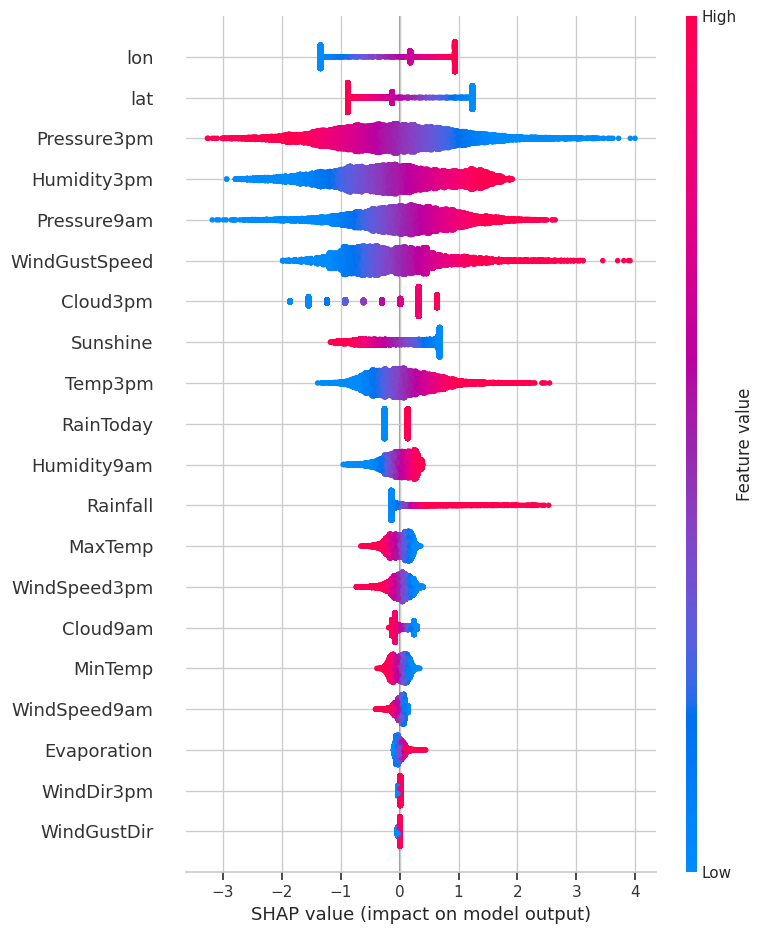

In [24]:
# Crear el objeto explainer
explainer = shap.LinearExplainer(model, X_train, feature_names=X_train.columns)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer(X_train)

# Crear un gráfico de resumen
shap.summary_plot(shap_values, X_train)

El grafico nos da una intuicion de que el modelo da valores alto de shap para variables que natualmente ayudan a explicar el fenomeno de la lluvia.

Por ejemplo altos valores de cantidad de lluvia del dia actual conlleva a altos valores shap. Es decir, conociendo que un dia como hoy hubo una gran cantidad de lluvia, nos ayuda a estimar con buena presicion que mañana es muy probable que llueva.

Otras variables, como la temperatura a las 3pm, que habiamos visto anteriormente que altas temperaturas insinuaban menos probabilidad de que mañana llueva. Es este grafico vemos que altas temperaturas conllevan a altos valores de shap. Esto se debe a que conocer que el dia actual tuvo una alta temperatura a dicha hora, ayuda a determinar que es probable que mañana no llueva.

La variable Presion a las 3pm tiene un amplio rango de valores shap. Si bien bajos valores de presion son de alta utilidad para predecir la presencia de lluvia, los valores de pression muy altos afectan negativamente a las prediccion del modelo.

Existen muchas otras variables que se mueven en rangos de valores acotados para valores shap. Esto indica que las mismas podrian ser descartadas o son menos importantes para estimar la variable objetivo.

El siguiente grafico tiene intencion de mostrar como el modelo actua ante un registro en especifico a la hora de hacer una prediccion.

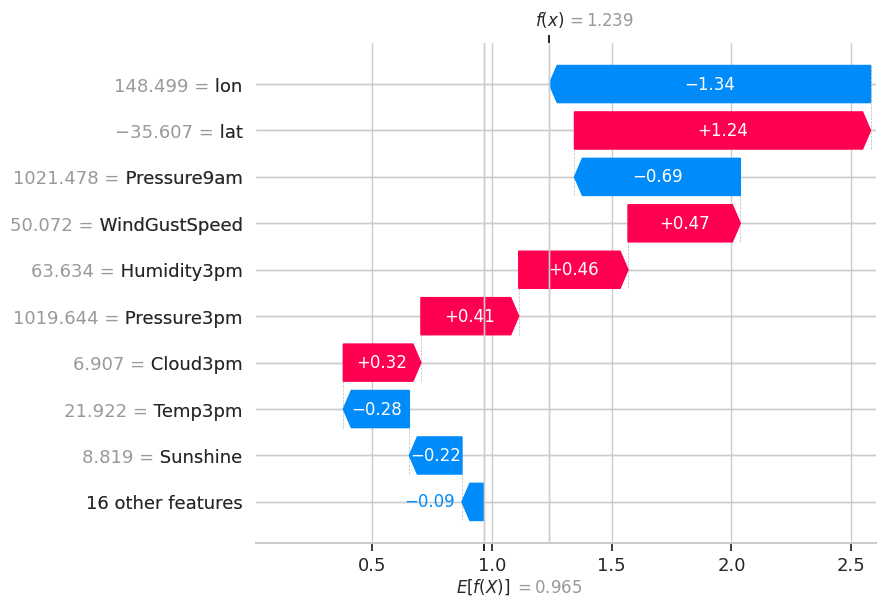

In [25]:
index=100
model.predict(X_test)[index] # filtramos un registro dado de los datos de validacion

shap_values = explainer(X_test) # explicabilidad de los datos de validacion

explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=X_train.columns)

shap.plots.waterfall(explanation)

Este grafico de cascada nos permite determinar que para este registro en especifico, cuyos valores de variable se visualizan a la izquierda, como es el impacto que tiene cada valor en el modelo.

Notamos por ejemplo que el conocer la longitud de la ciudad del registro resta significativamente para hacer la prediccion, por lo que esta variable afecta negativamente para este registro en particular.

Sin embargo, no pasa lo mismo con la latitud de la ciudad, ya que la misma de alta utilidad para explicar el modelo. Esto puede deberse a la mayor separacion entre las ciudades en este eje.

Podemos notar, por ejemplo, como la suposicon del inicio de que Sunshine seria de gran utilidad para explicar el modelo, resulta incorrecta aqui, ya que de hecho resta explicabilidad.

# **Conclusiones**

Este trabajo ha consistido en la preparacion y entendimiento de los datos y de los modelos de clasificacion. Los mismos han sufrido variantes y han sido mas o menos profundizados dependiendo del interes.

Lo que logramos hasta esta instancia es un modelo de regresion logisitca que optimiza las metricas generales de prediccion de presencia de lluvia de un dia posterior para las ciudades dadas de Australia.

El conjunto de datos tambien ha sido optimizado para maximizar el rendimiento de las predicciones favoreciendo (o no) al modelo.

El modelo puede ser explicado e interpretado, y comprendemos que puede ser mejorado debido a que en esta instancia conocemos cuales son las condiciones que hacen que el modelo de peor rendiemiento, o como minimo considerar estas condiciones a la hora de confiar en una prediccion por el modelo.